# Classification

Loading standard libraries

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
%matplotlib inline
np.random.seed(0)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

Loading internal abstractions

In [3]:
sys.path.append('..')
from weights import KernelComputer, KernelRegressor
from dataloader import LIBSVMLoader, FoldsGenerator
from classification import DF

### Choose datasets to play with

In [4]:
names = LIBSVMLoader.datasets
names = ['dna', 'svmguide2']

### Choose a kernel

In [5]:
kernel_type = 'Gaussian'  # 'Gaussian', 'Laplacian', 'Linear'

### Choose hyparameters for the simulations

In [6]:
nb_folds = 8                                              # number of folds
corruptions = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  # corruptions to test
sigmas = [1e0, 1e-1, 1e-2]                      # different kernel parameters to test
lambdas = [1e0, 1e-3, 1e-6]                    # different regularizations to test

Internal main script

In [7]:
t = time.time()
kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)

err_df, err_il, err_ac = {}, {}, {}
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

for name in names:
    print(name)
    
    loader = LIBSVMLoader(name)
    x, y = loader.get_trainset()
    
    index_to_corrupt = np.argmax(y.sum(axis=0))

    S = np.empty((*y.shape, len(corruptions)))
    for i, corruption in enumerate(corruptions):
        S[..., i] = loader.skewed_corruption(y, corruption, index_to_corrupt)
#         S[..., i] = loader.synthetic_corruption(y, corruption)
        
    err_df[name]= np.empty(shape_err)
    err_il[name]= np.empty(shape_err)
    err_ac[name]= np.empty(shape_err)
    
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    
    for fold in range(nb_folds):

        (x_train, S_train), (x_test, y_test) = floader()
        y_test = np.argmax(y_test, axis=1)
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape
        
        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma)

            for i_l, c_lambda in enumerate(lambdas):
                lambd = c_lambda / np.sqrt(n_train)
                kernel_reg.update_lambda(lambd)
                alpha = kernel_reg(x_test)
                alpha_train = kernel_reg(x_train)
                alpha_train += alpha_train.T

                for i_c, corruption in enumerate(corruptions):
                    s_train = S_train[..., i_c]

                    y_train = DF.disambiguation(alpha_train, s_train.astype(np.bool_))
                    y_df = np.argmax(alpha @ y_train, axis=1)
        
                    y_il = np.argmax(alpha @ s_train, axis=1)                    
                    
                    s_train = s_train / s_train.sum(axis=1)[:, np.newaxis]
                    y_ac = np.argmax(alpha @ s_train, axis=1)
                        
                    err_df[name][i_c, fold, i_s, i_l] = (y_df != y_test).mean()
                    err_il[name][i_c, fold, i_s, i_l] = (y_il != y_test).mean()                  
                    err_ac[name][i_c, fold, i_s, i_l] = (y_ac != y_test).mean()
print(time.time() - t)

dna
svmguide2
102.92331194877625


In [8]:
# best = np.array([['s0l0', 's1l0', 's2l0'], ['s0l1', 's1l1', 's2l1'], ['s0l2', 's1l2', 's2l2']]).reshape(-1)
n_c = len(corruptions)
mus, stds = np.empty((len(names), 3, n_c)), np.empty((len(names), 3, n_c))
for i, name in enumerate(names):
    for j, err in zip([0, 1, 2], [err_df, err_il, err_ac]):
        tmp = err[name].reshape((len(corruptions), nb_folds, -1))
        mu = tmp.mean(axis=1)
        ind = mu.argmin(axis=-1)
        for k in range(len(corruptions)):
            mus[i, j, k] = mu[k, ind[k]]
            stds[i, j, k] = tmp[k, :, ind[k]].std()
#         print(name, best[ind])

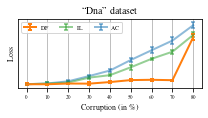

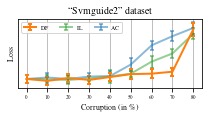

In [9]:
for i, name in enumerate(names):
    fig, ax = plt.subplots(figsize=(3, 1.75))
    c = ax.errorbar([100*i for i in corruptions[:-2]], mus[i, 2][:-2], .5*stds[i, 2][:-2], capsize=2, linewidth=2, capthick=2, color='C0', alpha=.5)
    b = ax.errorbar([100*i for i in corruptions[:-2]], mus[i, 1][:-2], .5*stds[i, 1][:-2], capsize=2, linewidth=2, capthick=2, color='C2', alpha=.5)
    a = ax.errorbar([100*i for i in corruptions[:-2]], mus[i, 0][:-2], .5*stds[i, 0][:-2], capsize=2, linewidth=2, capthick=2, color='C1')
    ax.legend([a, b, c], ['DF', "IL", "AC"], prop={'size':6}, ncol=3)
#     ax.legend([b, c], ["IL", "AC"], prop={'size':9}, ncol=2)
    ax.grid()
    ax.set_title(r"``" + name[0].upper() + name[1:] + "'' dataset", size=10)
    ax.set_ylabel(r'Loss', size=8)
    ax.set_xlabel(r'Corruption (in \%)', size=8)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(os.path.join('savings', 'cl', name + '.pdf'))